# Lecture 20 - Large Language Models

## Learning goals

- Use OpenAI's **Responses API** to build you own chatbot.
- Make a one-round conversation, then chain turns with history.
- Compare models (GPT-5, GPT-4o, o-series) on the same prompt and log latency and tokens.
- Understand **hallucinations** in LLMs and learn simple **retrieval-augmented generation**.


[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1miAN-emFKsUcH6rdULwp7rhJFbjR5fcF?usp=sharing)



For this lecture 20, it is recommended to run everything in Colab.

## 0. Setup
Install packages if needed and place an API key placeholder.


In [1]:
raise RuntimeError("Intentional stop: ending execution here.")

RuntimeError: Intentional stop: ending execution here.

## 1. Listing available models

The OpenAI API exposes many models. Use the `models.list()` method to see models available to your account. This call requires a valid API key.


In [2]:
# List available models (requires a valid API key)
models = client.models.list()
for available_models in models.data[:50]:
  print(available_models.id)



gpt-4-0613
gpt-4
gpt-3.5-turbo
gpt-5-search-api-2025-10-14
gpt-realtime-mini
gpt-realtime-mini-2025-10-06
sora-2
sora-2-pro
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
o1-mini-2024-09-12
o1-mini
gpt-4o-realtime-preview-2024-10-01
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
computer-use-preview
o3-mini


## 2. One‑round conversation

Let’s ask a simple chemistry question to GPT‑4o and its smaller variants using the **Responses API**.

We will calculate the number of moles of **ethanol (C₂H₅OH)** in 50 mL given a density of 0.789 g/mL. The request is supplied via the `input` parameter rather than `messages`.


In [3]:
# Define the prompt for a one‑round question
prompt = "Calculate the number of moles of ethanol in 50 mL. Just show your results in one sentence."

response = client.responses.create(
     model="gpt-4o",
     input=prompt)

print(response.output_text)


The number of moles of ethanol in 50 mL is approximately 0.86 moles, assuming the density of ethanol is 0.789 g/mL and the molar mass is 46.07 g/mol.


For your reference below is the correct answer based on accurate calculation.

In [4]:
# Given data
volume_ml = 50
density_ethanol = 0.789  # g/mL
molar_mass_ethanol = 46.07  # g/mol

# Calculate mass and moles
mass_ethanol = density_ethanol * volume_ml
moles_ethanol = mass_ethanol / molar_mass_ethanol

print(f"The number of moles of ethanol in {volume_ml} mL is approximately {moles_ethanol:.3f} mol")


The number of moles of ethanol in 50 mL is approximately 0.856 mol


You can also ask questions like SMILES and IUPAC names in this way:

In [5]:
prompt = "What are the SMILES notation and IUPAC name of aspirin?"

response1 = client.responses.create(
     model="gpt-4o",
     input=prompt)

print(response1.output_text)

The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name for aspirin is 2-(acetyloxy)benzoic acid.


Now you can change the model to `gpt-4.1` and see it behaves slightly differently:

In [6]:
response2 = client.responses.create(
     model="gpt-4.1",
     input=prompt)

print(response2.output_text)

**Aspirin** is a widely used medication, commonly known as acetylsalicylic acid.

### 1. **SMILES Notation**
```
CC(=O)Oc1ccccc1C(=O)O
```

### 2. **IUPAC Name**
**2-acetyloxybenzoic acid** (or fully: **2-(acetyloxy)benzoic acid**)

#### **Summary Table**

| Property             | Value                          |
|----------------------|--------------------------------|
| **SMILES**           | CC(=O)Oc1ccccc1C(=O)O          |
| **IUPAC Name**       | 2-acetyloxybenzoic acid        |

Let me know if you need the structure or any additional details!


Here is for `gpt-3.5` response:

In [7]:
response3 = client.responses.create(
     model="gpt-3.5-turbo",
     input=prompt)

print(response3.output_text)

The SMILES notation for aspirin is O=C(C)Oc1ccccc1C(=O)O.

The IUPAC name for aspirin is 2-acetyloxybenzoic acid.


Now, we can consider a new paramter call `temperature`. The higher this value the more "creative" model will be. If `temperature` is `0`, the model will respond more similarly (but not always the same!).

Below you will see, even if the answer to asprin question will be the same, the model answers differently at `temperature = 1` while gives the same answer in `temperature = 0`.

In [8]:
prompt = "What are the SMILES notation and IUPAC name of aspirin?"


# Run three times with temperature = 1
for i in range(1, 4):
    response = client.responses.create(
        model="gpt-4o",
        temperature=1,
        input=prompt
    )
    print(f"\n--- Response {i} (temperature=1) ---")
    print(response.output_text)

print("*"*50)
# Run three times with temperature = 0
for i in range(1, 4):
    response3 = client.responses.create(
        model="gpt-4o",
        temperature=0,
        input=prompt
    )
    print(f"\n--- Response {i} (temperature=0) ---")
    print(response3.output_text)


--- Response 1 (temperature=1) ---
The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name for aspirin is 2-acetyloxybenzoic acid.

--- Response 2 (temperature=1) ---
The SMILES notation for aspirin is: `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name for aspirin is: 2-acetyloxybenzoic acid.

--- Response 3 (temperature=1) ---
The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name of aspirin is **2-acetoxybenzoic acid**.
**************************************************

--- Response 1 (temperature=0) ---
The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name of aspirin is **2-acetyloxybenzoic acid**.

--- Response 2 (temperature=0) ---
The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name of aspirin is **2-acetyloxybenzoic acid**.

--- Response 3 (temperature=0) ---
The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name of aspirin is **2-acetyloxybenzoic acid**.


Another paramter `max_output_tokens` will control how long the answer will be.

In [9]:
prompt = "What are the SMILES notation and IUPAC name of aspirin?"

response4 = client.responses.create(
     model="gpt-4o",
     temperature=0.5,
     max_output_tokens = 20,
     input=prompt)

print(response4.output_text)

The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C


In above case it actually doesnt finish answering the entire question.

In [10]:
prompt = "What are the SMILES notation and IUPAC name of aspirin?"

response5 = client.responses.create(
     model="gpt-4o",
     temperature=0.5,
     max_output_tokens = 50,
     input=prompt)

print(response5.output_text)

The SMILES notation for aspirin is `CC(=O)OC1=CC=CC=C1C(=O)O`.

The IUPAC name for aspirin is **2-acetyloxybenzoic acid**.


You can also control your prompt to guide the model answer the questions in designed format.

In [11]:
prompt = "Is `2-acetoxybenzoic acid` the IUPAC name for aspirin? Answer Y or N. No explaination needed."

response6a = client.responses.create(
     model="gpt-4o",
     temperature=0.5,
     max_output_tokens = 50,
     input=prompt)

print(response6a.output_text)

Y


In [12]:
prompt = "Is `3-acetoxybenzoic acid` the IUPAC name for aspirin? Answer Y or N. No explaination needed."

response6b = client.responses.create(
     model="gpt-4o",
     temperature=0.5,
     max_output_tokens = 50,
     input=prompt)

print(response6b.output_text)

N


However, for some harder questions, both human and AI need to "think" or do reasoning before answer directly. In more advanced models like `gpt-5`, we can do this with specifying `reasoning_effort` (`low`, `medium`, or `high`) to allow model to "think" for longer time before answering the question.

Note: `temperature` feature will be disabled when you choose to do reasoning.
The `verbosity` parameter controls the length of the response (`low`, `medium`, or `high`)

In [13]:
prompt = """
If aspirin is synthesized using ^18O-labeled acetic anhydride, which atom in aspirin retains the ^18O label, and what are its labeled SMILES and IUPAC name?
"""

response = client.responses.create(
     model="gpt-5",
      reasoning={ "effort": "low" },
      #text={ "verbosity": "low" },  #This is optional to specify verbosity
     input=prompt)

print(response.output_text)

- The 18O label ends up as the carbonyl oxygen of the acetyl group in aspirin (the ester C=O of the acetyl moiety).
- Labeled SMILES: CC(=[18O])Oc1ccccc1C(=O)O
- IUPAC name: 2-(acetyloxy)benzoic acid, with the acetyl carbonyl oxygen labeled as oxygen-18 (i.e., 2-(acetyloxy)benzoic acid-18O at the acetyl C=O).


Finally, an additional thing you can include in `instructions` is the **system prompt**.

A system prompt is a **global** instruction gives GPT its role and rules, guiding tone and behavior for the whole chat.
While a user prompt you see above is what you type to ask a question or request a task.
The system sets context; the user drives each response.

In [14]:
prompt = "Is `2-acetoxybenzoic acid` the IUPAC name for aspirin?"


response = client.responses.create(
    model="gpt-5",
    instructions="You are a chemistry assistant. Always answer only with 'Y' or 'N' and give no explanation.",
    input= prompt
)

print(response.output_text)

Y


As you see below, when there is a conflict, the system prompt will likely **overide** the user prompt.

In [15]:
prompt = "Is `2-acetoxybenzoic acid` the IUPAC name for aspirin?  Always answer only with 'Yes!' or 'No!' and give 10 words explanation. "


response = client.responses.create(
    model="gpt-5",
    instructions="You are a chemistry assistant. Always answer only with 'Y' or 'N' and give no explanation.",
    input= prompt
)

print(response.output_text)

N


Above `instructions` will work similarly as below using `role = system` and put the text in `content`:

In [16]:
response = client.responses.create(
    model="gpt-4o",
    input=[
        {
            "role": "system",
            "content": "Always answer only with 'Y' or 'N' and give no explanation."
        },
        {
            "role": "user",
            "content": "Is `2-acetoxybenzoic acid` the IUPAC name for aspirin?"
        }
    ]
)

print(response.output_text)

Y


So, why we want to learn using the API instead of just chatting on the website?

When you want to automate tasks or process data programmatically — for example, checking multiple sentences for the presence of an IUPAC name.
In the web chat, you’d have to paste and check them one by one, but with the API, you can run a for loop to evaluate all 10 automatically and collect the results.

In [17]:
sentences = [
    "Aspirin is also known as 2-acetoxybenzoic acid.",
    "Water is essential for life.",
    "The compound N-(4-hydroxyphenyl)acetamide is commonly called paracetamol.",
    "Carbon dioxide is a greenhouse gas.",
    "The IUPAC name for caffeine is 1,3,7-trimethylxanthine.",
    "Sodium chloride is used in cooking.",
    "Acetone is also called propan-2-one.",
    "This sentence talks about chemical bonding.",
    "Ethanoic acid is another name for acetic acid.",
    "Oxygen supports combustion."
    # you can image when we have 1000+ sentences like above.
]

for s in sentences:
    response = client.responses.create(
        model="gpt-5-nano",
        instructions="You are a chemistry assistant. Respond only with Y or N. No explaination needed.",
        input=f"Does this sentence mention an IUPAC name? '{s}'",
    )
    print(s, "->", response.output_text)


Aspirin is also known as 2-acetoxybenzoic acid. -> Y
Water is essential for life. -> N
The compound N-(4-hydroxyphenyl)acetamide is commonly called paracetamol. -> Y
Carbon dioxide is a greenhouse gas. -> Y
The IUPAC name for caffeine is 1,3,7-trimethylxanthine. -> Y
Sodium chloride is used in cooking. -> Y
Acetone is also called propan-2-one. -> Y
This sentence talks about chemical bonding. -> N
Ethanoic acid is another name for acetic acid. -> Y
Oxygen supports combustion. -> Y


Below is another example when you try to unify the name entities in your inventory of lab notebook, which will later make you calculation of MW easier:

In [18]:
sentences = [
    "zinc nitrate heptahydrate",
    "Zn(NO3)37H2O",
    "Zn(NO3)3 7H2O",
    "copper(II) sulfate pentahydrate",
    "CuSO45H2O",
    "CuSO4.5H2O",
    "magnesium chloride hexahydrate",
    "MgCl26H2O",
    "nickel(II) sulfate hexahydrate",
    "NiSO46H2O"
    # imagine 1000+ like this
]

for s in sentences:
    response = client.responses.create(
        model="gpt-4o",
        instructions="Convert each compound name or formula into its standardized chemical formula with dot notation (e.g., Zn(NO3)2·6H2O). Output formula only.",
        input=f"Standardize this compound: {s}"
    )
    print(s, "->", response.output_text)


zinc nitrate heptahydrate -> Zn(NO3)2·7H2O
Zn(NO3)37H2O -> Zn(NO3)3·7H2O
Zn(NO3)3 7H2O -> Zn(NO3)3·7H2O
copper(II) sulfate pentahydrate -> CuSO4·5H2O
CuSO45H2O -> CuSO4·5H2O
CuSO4.5H2O -> CuSO4·5H2O
magnesium chloride hexahydrate -> MgCl2·6H2O
MgCl26H2O -> MgCl2·6H2O
nickel(II) sulfate hexahydrate -> NiSO4·6H2O
NiSO46H2O -> NiSO4·6H2O


## 3. Multi‑turn conversation

To maintain context across turns with the Responses API, pass a list of items to the `input` parameter. Each item is a dictionary with a `role` ("system", "developer", "user", or "assistant") and `content`. The API stores conversation history by default; you can also manage history manually by appending previous outputs. Here we build a small dialogue about **metal–organic frameworks (MOFs)** and SMILES notation.


In [19]:
# Start the conversation history
history = [
    {"role": "system", "content": "You are a helpful chemistry tutor. Keep your answers short."},
    {"role": "user", "content": "What is the most widely reported metal organic framework (MOF)?"}
]

# First turn – ask about MOFs
first_resp = client.responses.create(model="gpt-5-mini", input=history)
print(first_resp.output_text)

Historically the prototypical and most widely reported MOF is MOF-5 (IRMOF‑1, Zn4O(BDC)3) — it’s the classic, highly cited early MOF.  
For practical/stability-focused work, ZIF‑8 (Zn(mIm)2) is also extremely widely reported and heavily used in applications.


Now, we basically add the latest `output_text` back to `history`, add follow-up questions, and use it as the `input` for next round, so model will "see" the previous conversation (including the answer from itself) to answer next around of conversation.

In [20]:
history.append({"role": "assistant", "content": first_resp.output_text})
history


[{'role': 'system',
  'content': 'You are a helpful chemistry tutor. Keep your answers short.'},
 {'role': 'user',
  'content': 'What is the most widely reported metal organic framework (MOF)?'},
 {'role': 'assistant',
  'content': 'Historically the prototypical and most widely reported MOF is MOF-5 (IRMOF‑1, Zn4O(BDC)3) — it’s the classic, highly cited early MOF.  \nFor practical/stability-focused work, ZIF‑8 (Zn(mIm)2) is also extremely widely reported and heavily used in applications.'}]

Below we add the follow up quetsions and sent to the model:

In [21]:
history.append({"role": "assistant",  "content":  "I dont quite understand the MOFs you mentioned in your previous answer, explain in short."})
history

[{'role': 'system',
  'content': 'You are a helpful chemistry tutor. Keep your answers short.'},
 {'role': 'user',
  'content': 'What is the most widely reported metal organic framework (MOF)?'},
 {'role': 'assistant',
  'content': 'Historically the prototypical and most widely reported MOF is MOF-5 (IRMOF‑1, Zn4O(BDC)3) — it’s the classic, highly cited early MOF.  \nFor practical/stability-focused work, ZIF‑8 (Zn(mIm)2) is also extremely widely reported and heavily used in applications.'},
 {'role': 'assistant',
  'content': 'I dont quite understand the MOFs you mentioned in your previous answer, explain in short.'}]

In [22]:
second_resp = client.responses.create(model="gpt-5-mini", input=history)
print(second_resp.output_text)

A MOF (metal–organic framework) is a crystalline network of metal nodes connected by organic linkers that makes porous materials with very high surface area.

MOF‑5 (IRMOF‑1, Zn4O(BDC)3)
- Composition: Zn4O clusters connected by BDC linkers (BDC = benzene‑1,4‑dicarboxylate, aka terephthalate).  
- Features: cubic porous framework, very high surface area, one of the first widely reported MOFs.  
- Drawback: not very water‑stable; mostly used as a model system.

ZIF‑8 (Zn(mIm)2)
- Composition: Zn2+ nodes bridged by 2‑methylimidazolate (mIm) linkers.  
- Features: zeolite‑like topology, excellent thermal/chemical stability (including moisture), flexible pores that can gate molecules.  
- Uses: gas separation, catalysis, membranes, and many applied studies.


Adding the previous assistant reply into the history tells the model what it already said. This simple technique lets you build multi‑round dialogues without losing context.

Alternatively, in the `responses` API you can also pass a previous `response.id` to manage conversation state:


In [23]:
first = client.responses.create(
    model="gpt-5-mini",
    instructions="You are a helpful chemistry tutor. Keep your answers short.",
    input="What is the most widely reported metal organic framework (MOF)?")
print("Turn 1:", first.output_text)

follow = client.responses.create(
  model="gpt-5-mini",
  previous_response_id=first.id, #do this instead of append the history
  input=[{"role": "user", "content": "I dont quite understand the MOFs you mentioned in your previous answer, explain in short."}],
    )
print("Turn 2:", follow.output_text)

Turn 1: Historically the most widely reported is MOF-5 (aka IRMOF-1, Zn4O(BDC)3) — the prototypical Yaghi MOF frequently used as a model system. (Other very widely reported MOFs include ZIF-8 and UiO-66.)
Turn 2: Here are short, plain explanations for each:

- MOF-5 (aka IRMOF-1)  
  - Composition/structure: Zn4O inorganic nodes linked by terephthalate (benzene-1,4-dicarboxylate, BDC) linkers to form a cubic porous network.  
  - Key points: prototype MOF, very high surface area and porosity, widely used as a model system.  
  - Limitation: sensitive to moisture.

- ZIF-8  
  - Composition/structure: a zeolitic imidazolate framework made from Zn2+ nodes connected by 2‑methylimidazolate linkers; structure resembles zeolites.  
  - Key points: excellent chemical and thermal stability, relatively small pore apertures that give size‑selective transport, often used in gas separation, membranes, and delivery.  

- UiO-66  
  - Composition/structure: built from robust Zr6 oxo/hydroxo clusters

Now, let's consider, we can talk to agent to help us improve the reaction yield by asking it to improve the conditions iteratively. In this case the agent will be able to see previous reaction suggestion history and the respective reaction outcome. Note that LLM generally gives such "prediction" mostly by "educated guess" and their "chemical intutitions" obtained during the training. There is actually no calculation or math done in this suggesting condition steps. Still, it will show you how they can act like a human chemist to gradually improve the reaction condition.

In [24]:
# 1) Load dataset
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/mof_yield_dataset.csv"
df = pd.read_csv(url)

# 2) Choose target MOFLinker
target = "O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1"

# 3) Subset and grids
sub = df[df["smiles"] == target][["temperature", "time_h", "yield"]].copy()

valid_temps = np.sort(sub["temperature"].unique())
valid_times = np.sort(sub["time_h"].unique())
print(valid_temps)
print(valid_times )
sub

[ 25  40  55  70  85 100 115 130 155 160]
[ 12  24  36  48  60  72  84  96 108 120]


,temperature,time_h,yield
3,25,12,0.21
13,25,12,0.29
23,25,12,0.24
33,25,12,0.25
43,25,12,0.15
...,...,...,...
19953,160,120,0.48
19963,160,120,0.17
19973,160,120,0.35
19983,160,120,0.00


Now we will guide LLM to propose one reaction condition for each conversation, then use the real data from this dataet to provide the result outcome as the follow-up conversation and ask it to suggest the next one.

In [25]:

# 4) Utility functions
def snap_to_grid(x, grid):
    return float(grid[np.abs(grid - x).argmin()])

def score_yield(temp, time_h):
    rows = sub[(sub["temperature"] == temp) & (sub["time_h"] == time_h)]
    return float(rows["yield"].max()) if not rows.empty else float("nan")

def parse_json_suggestion(text):
    try:
        d = json.loads(text.strip())
        return float(d["temperature_C"]), float(d["time_h"])
    except Exception:
        nums = re.findall(r"(\d+\.?\d*)", text)
        return (float(nums[0]), float(nums[1])) if len(nums) >= 2 else (None, None)

# 5) Starting condition
T0 = 25.0
H0 = 12.0
y0 = score_yield(T0, H0)
print(f"Start -> T: {T0:.0f} °C, t: {H0:.0f} h, yield: {y0:.2f}")

# 6) Build system & first user message
temp_grid_str = ", ".join(map(str, valid_temps))
time_grid_str = ", ".join(map(str, valid_times))

system_prompt = (
    "You are an experimental chemistry assistant optimizing MOF yield. "
    "Choose only from the allowed grids provided. "
    "Respond strictly in JSON with keys: temperature_C, time_h. "
    "No text outside JSON. Example: {\"temperature_C\": 115, \"time_h\": 72}"
)

first_user = (
    f"We are optimizing yield for SMILES: {target}. "
    f"Allowed temperature (°C) levels -> [{temp_grid_str}] "
    f"Allowed time_h (hours) levels -> [{time_grid_str}] "
    f"Here's a start: {T0:.0f} °C for {H0:.0f} h with yield {y0:.2f}. "
    "Suggest a new condition to improve yield."
)

# 7) Initialize LLM and tracking
history = [{"role": "system", "content": system_prompt},
           {"role": "user", "content": first_user}]

ROUNDS = 15
gpt_best_T, gpt_best_H, gpt_best_y = T0, H0, y0
gpt_best_over_time = [gpt_best_y]

# --- reproducible random baseline ---
random_seed = 42
rng = random.Random(random_seed)
base_best_T, base_best_H, base_best_y = T0, H0, y0
baseline_best_over_time = [base_best_y]

for i in range(1, ROUNDS + 1):
    print(f"\n--- Round {i} ---")
    resp = client.responses.create(model="gpt-4o", input=history, temperature=0)
    suggestion = resp.output_text.strip()
    print("Model raw:", suggestion)

    # Parse and evaluate
    T_sug, H_sug = parse_json_suggestion(suggestion)
    if T_sug is None:
        T_sug, H_sug = T0, H0
    Tq = snap_to_grid(T_sug, valid_temps)
    Hq = snap_to_grid(H_sug, valid_times)

    y = score_yield(Tq, Hq)
    print(f"LLM eval -> grid {Tq:.0f} °C, {Hq:.0f} h, yield {y:.2f}")

    if y > gpt_best_y:
        gpt_best_T, gpt_best_H, gpt_best_y = Tq, Hq, y
    gpt_best_over_time.append(gpt_best_y)

    feedback = (f"Observed yield {y:.2f} at {Tq:.0f} °C, {Hq:.0f} h. "
                f"Best so far {gpt_best_y:.2f} at {int(gpt_best_T)} °C, {int(gpt_best_H)} h. "
                "Suggest another JSON condition from the allowed grids to improve yield.")
    history += [{"role": "assistant", "content": suggestion},
                {"role": "user", "content": feedback}]

    # Random baseline: reproducible random draws
    Tr = float(rng.choice(valid_temps))
    Hr = float(rng.choice(valid_times))
    yr = score_yield(Tr, Hr)
    print(f"Baseline eval -> grid {Tr:.0f} °C, {Hr:.0f} h, yield {yr:.2f}")
    if yr > base_best_y:
        base_best_T, base_best_H, base_best_y = Tr, Hr, yr
    baseline_best_over_time.append(base_best_y)

print("\nFinal best by LLM:")
print(f"T: {int(gpt_best_T)} °C, t: {int(gpt_best_H)} h, yield: {gpt_best_y:.2f}")
print("Final best baseline:")
print(f"T: {int(base_best_T)} °C, t: {int(base_best_H)} h, yield: {base_best_y:.2f}")


Start -> T: 25 °C, t: 12 h, yield: 0.44

--- Round 1 ---
Model raw: {"temperature_C": 55, "time_h": 48}
LLM eval -> grid 55 °C, 48 h, yield 0.54
Baseline eval -> grid 40 °C, 12 h, yield 0.50

--- Round 2 ---
Model raw: {"temperature_C": 70, "time_h": 72}
LLM eval -> grid 70 °C, 72 h, yield 0.61
Baseline eval -> grid 85 °C, 48 h, yield 0.64

--- Round 3 ---
Model raw: {"temperature_C": 85, "time_h": 96}
LLM eval -> grid 85 °C, 96 h, yield 0.61
Baseline eval -> grid 70 °C, 36 h, yield 0.53

--- Round 4 ---
Model raw: {"temperature_C": 100, "time_h": 72}
LLM eval -> grid 100 °C, 72 h, yield 0.81
Baseline eval -> grid 40 °C, 108 h, yield 0.43

--- Round 5 ---
Model raw: {"temperature_C": 115, "time_h": 72}
LLM eval -> grid 115 °C, 72 h, yield 0.85
Baseline eval -> grid 40 °C, 120 h, yield 0.51

--- Round 6 ---
Model raw: {"temperature_C": 130, "time_h": 72}
LLM eval -> grid 130 °C, 72 h, yield 0.74
Baseline eval -> grid 115 °C, 12 h, yield 0.63

--- Round 7 ---
Model raw: {"temperature_C":

The plot below compares the LLM’s performance with random guessing. You can see that the LLM **improves over successive rounds**, using the conversation history to suggest increasingly better conditions.


In this example, the model wasn’t given much background information—so its behavior resembles that of a chemist starting from limited context. While the absolute performance isn’t optimal, it clearly demonstrates how an LLM can be integrated into an **active learning** workflow to iteratively guide experimental optimization.

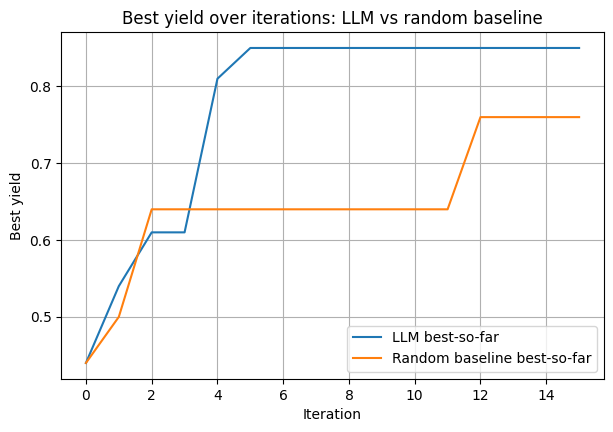

In [26]:

# 8) Plot best-over-time for LLM vs random baseline
iters = list(range(0, ROUNDS + 1))
plt.figure(figsize=(7, 4.5))
plt.plot(iters, gpt_best_over_time, label="LLM best-so-far")
plt.plot(iters, baseline_best_over_time, label="Random baseline best-so-far")
plt.xlabel("Iteration")
plt.ylabel("Best yield")
plt.title("Best yield over iterations: LLM vs random baseline")
plt.legend()
plt.grid(True)
plt.show()

Below is the history record of this entire conversational reaction improvement process.

In [27]:
history

[{'role': 'system',
  'content': 'You are an experimental chemistry assistant optimizing MOF yield. Choose only from the allowed grids provided. Respond strictly in JSON with keys: temperature_C, time_h. No text outside JSON. Example: {"temperature_C": 115, "time_h": 72}'},
 {'role': 'user',
  'content': "We are optimizing yield for SMILES: O=C(O)c1cc(C(=O)O)cc(C(=O)O)c1. Allowed temperature (°C) levels -> [25, 40, 55, 70, 85, 100, 115, 130, 155, 160] Allowed time_h (hours) levels -> [12, 24, 36, 48, 60, 72, 84, 96, 108, 120] Here's a start: 25 °C for 12 h with yield 0.44. Suggest a new condition to improve yield."},
 {'role': 'assistant', 'content': '{"temperature_C": 55, "time_h": 48}'},
 {'role': 'user',
  'content': 'Observed yield 0.54 at 55 °C, 48 h. Best so far 0.54 at 55 °C, 48 h. Suggest another JSON condition from the allowed grids to improve yield.'},
 {'role': 'assistant', 'content': '{"temperature_C": 70, "time_h": 72}'},
 {'role': 'user',
  'content': 'Observed yield 0.61

## 4. Hallucinations

**Hallucination** is defined as a plausible but false statement generated by a model. They arise because training procedures reward confident answers even when data are sparse. GPT‑5 reduces hallucinations but they still occur, especially when asked about nonexistent compounds.


Here we ask about a MOF called *MOF‑521* and its crystal structure.

Note that this aluminum MOF **does exist** ( [link ](https://onlinelibrary.wiley.com/doi/full/10.1002/anie.202311983)). However, it was reported on Oct. 2023 and after the checkpoint for earlier models like `gpt-3.5`.


In [28]:
# Define a hallucination‑inducing prompt
hallucination_prompt = "Describe the metal and organic linker used in synthesis of the MOF-521 in 20 words."

response_h1 = client.responses.create(model="gpt-3.5-turbo", input=hallucination_prompt)
print(response_h1.output_text)



MOF-521 uses Zr4+ ions as metal linker and 2,6-naphthalene dicarboxylate as organic linker in a three-dimensional crystalline structure.


As you see, the model does not answer with Al (aluminium) before this MOF is not on the training set. The name `MOF-521` itself sounds similar to other more common MOFs like `MOF-5`, `MOF-125` or `521-MOF`, therefore the model starts to halluciate.

In [29]:
response_h2 = client.responses.create(model="gpt-4.1", input=hallucination_prompt)
print(response_h2.output_text)

MOF-521 uses zirconium (Zr) metal clusters and tetratopic tetrakis(4-carboxyphenyl)methane (TCPM) as the organic linker.


In [30]:
response_h3 = client.responses.create(model="gpt-4o", input=hallucination_prompt)
print(response_h3.output_text)

MOF-521 uses zirconium metal ions and a 4,4',4''-s-Triazine-2,4,6-triyl-tribenzoic acid (TATB) as the organic linker.


In [31]:
response_h4 = client.responses.create(model="gpt-5", input=hallucination_prompt)
print(response_h4.output_text)

MOF-521 employs Zr6-oxo/hydroxo cluster metal nodes coordinated to tetrakis(4-carboxyphenyl)porphyrin (H4TCPP) linkers, forming a robust porphyrinic zirconium framework.


Below is answer example where model starts to "guess" the answer when asked the MW of an organic linker.

The correct answer is 330.24 g/mol ([link](https://pubchem.ncbi.nlm.nih.gov/compound/15840397)). You will see except gpt-5, all guessing are wrong, while gpt-5 use the reasoning to improve the performance (so it takes longer to answer).

In [32]:
import time

def test_response_time(prompt, instruction, models):
    for m in models:
        start = time.time()
        r = client.responses.create(model=m, input=prompt, instructions=instruction)
        t = time.time() - start
        print(f"{m}: {r.output_text.strip()}  ⏱ {t:.2f}s")

models = ["gpt-3.5-turbo", "gpt-4o", "gpt-4.1", "gpt-5-mini", "gpt-5"]
prompt = "What is the molecular weight of biphenyl-3,3',5,5'-tetracarboxylic acid?"
instruction = "Answer in 5 words."


test_response_time(prompt, instruction, models)


gpt-3.5-turbo: 620.17 g/mol  ⏱ 0.66s
gpt-4o: 322.20 g/mol  ⏱ 0.60s
gpt-4.1: 366.28 grams per mole.  ⏱ 1.36s
gpt-5-mini: Approximately 330.25 grams per mole  ⏱ 19.14s
gpt-5: Molar mass is 330.24 g/mol.  ⏱ 15.75s


The examples above show that a model can sometimes fabricate an answer — this is known as a hallucination. While it’s impossible to eliminate hallucinations entirely, several approaches can help reduce them. These include prompt engineering, retrieval-augmented generation (RAG), chain-of-thought reasoning, fine-tuning, and function calling. Other effective methods include grounding outputs with verified databases, enforcing structured response formats (like JSON schemas), post-processing with fact-checking tools, and using model ensembles or human-in-the-loop review.

For now, remember that whenever you use an LLM, it may still produce convincing but incorrect information.

Below, we’ll demonstrate a simple example of a basic RAG setup to help illustrate this concept.

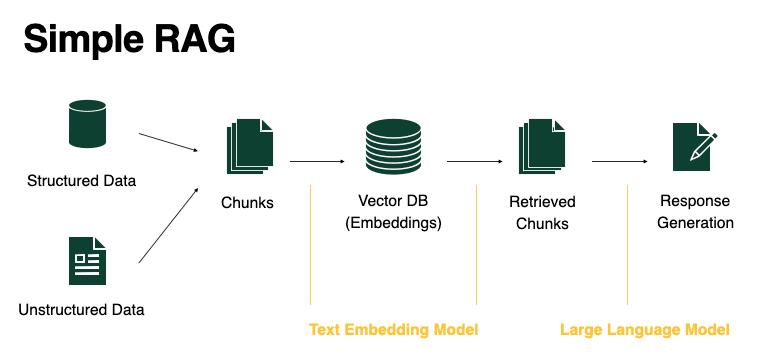

Image Credit (Chaoyu Yang) and Further Reading: [link](https://www.bentoml.com/blog/building-rag-with-open-source-and-custom-ai-models)

So what is **retrieval‑augmented generation (RAG)**?

An effective way to reduce hallucinations is to **ground** the model’s responses in external knowledge. In a simple retrieval‑augmented generation (RAG) pipeline, a search component retrieves relevant documents which are fed to the model. Naive RAG performs a single retrieval step and passes the results directly to the model.


Below is a minimal example of how you might implement a naive retrieval step using text embedding and cosine similarity. We create a small document collection of chemistry snippets and then retrieve the most similar document for a query.


In [33]:
# ---------------------------
# 1) Data: 10 chunks (20–100 words each)
#    One chunk contains PubChem info with molecular weight 330.24 g/mol, CID 15840397.
# ---------------------------
chunks = [
    {
        "id": "wiki-1",
        "source": "https://en.wikipedia.org/wiki/Biphenyl",
        "text": (
            "Biphenyl is an aromatic hydrocarbon composed of two connected benzene rings. "
            "Many substituted biphenyls are used in materials and coordination chemistry. "
            "Unsubstituted biphenyl has formula C12H10. Substituted variants may carry carboxylate groups "
            "that change physical properties and reactivity. Safety data and handling vary by substitution pattern."
        ),
    },
    {
        "id": "wiki-2",
        "source": "https://en.wikipedia.org/wiki/Carboxylic_acid",
        "text": (
            "Carboxylic acids contain the functional group COOH. Multicarboxylic acids have multiple such groups "
            "that affect acidity, solubility, and reactivity. Their salts and esters are common in synthesis "
            "and polymer formation. Molecular weights depend on substitution and ring systems."
        ),
    },
    {
        "id": "inventory-1",
        "source": "local database: inventory 2024-11",
        "text": (
            "Stock item: NaOH. Bottle states batch number and supplier. "
            "Record contains storage conditions: cool and dry, desiccated. No explicit molecular weight field, only supplier code. "
        ),
    },
    {
        "id": "inventory-2",
        "source": "local database: synthesis notes 2024-10",
        "text": (
            "Trial syntheses with a tetracarboxylic biphenyl linker and zinc nitrate gave variable crystallinity. "
            "Yields depended on solvent ratio and temperature program. "
            "No reliable molecular weight entry was recorded in these notes."
        ),
    },
    {
        "id": "review-chem-1",
        "source": "https://pubs.acs.org/doi/10.1021/acsomega.7b01964",
        "text": (
            "Multidentate flexible linkers, for example, di, tri, and tetra carboxylates, are the most widely used linkers in MOF chemistry. "
            "Such linkers coordinate with metal ions to form a wide range of multinuclear nodes with predictable geometries such as binuclear paddle-wheel units, tri, or tetranuclear units."
             "In this regard, aromatic tetracarboxylate linkers are particularly utilitarian because of the more number of coordinating sites as well as the rich π-electron density. "
             "MOFs constructed from such π-electron-rich tetracarboxylate ligands have pore surfaces studded with a large number of oxygen atoms providing better interactions with gas molecules"

        ),
    },
    {
        "id": "pubchem-15840397",
        "source": "https://pubchem.ncbi.nlm.nih.gov/compound/15840397",
        "text": (
            "PubChem record for Biphenyl-3,3',5,5'-tetracarboxylic Acid. Synonyms: BPTC acid, Biphenyl-3,3′,5,5′-tetracarboxylic acid. "
            "CID: 15840397. Molecular formula: C16H10O8. Molecular weight: 330.24 g/mol. Depositor provided identifiers, "
            "SMILES and InChI are available on the page. Data source: PubChem Compound 15840397."
        ),
    },
    {
        "id": "supplier-cat-1",
        "source": "https://www.ambeed.com/metal-organic-frameworks-(mof)-linkers.html",
        "text": (
                "While long ligands increase pore size, they often reduce structural stability; conversely, short and rigid ligands promote higher crystallinity. "
                "Ligand functional groups not only form coordination bonds but also allow post-synthetic modification (PSM) to introduce specific recognition sites "
                "(e.g., Lewis acid/base sites, hydrogen-bond donors/acceptors), optimizing performance in gas adsorption, catalysis, or sensing."
        ),
    },
    {
        "id": "wiki-3",
        "source": "https://en.wikipedia.org/wiki/Molar_mass",
        "text": (
            "Molar mass is the mass of a given substance divided by the amount of substance. "
            "Units are g/mol. For organic compounds, it is calculated from atomic weights of constituent elements. "
            "Databases such as PubChem and supplier catalogs often list molar mass directly."
        ),
    },
    {
        "id": "inventory-3",
        "source": "local database: receiving log 2025-01",
        "text": (
            "Received: formic acid, sealed container. Checked against purchase order and stored in cabinet A. "
        ),
    },
    {
        "id": "methods-1",
        "source": "https://zhenglab.wustl.edu/",
        "text": (
            "When checking molecular weight, verify against a reliable chemical database or a certificate of analysis. "
            "Cross-check names and synonyms to avoid confusion with isomers or salts. Confirm that the entry refers to the free acid."
        ),
    },
]

query = "What is the molecular weight of biphenyl-3,3',5,5'-tetracarboxylic acid?"


emb_inputs = [query] + [c["text"] for c in chunks]


Below is how they look like before turning into vectors:

In [34]:
emb_inputs

["What is the molecular weight of biphenyl-3,3',5,5'-tetracarboxylic acid?",
 'Biphenyl is an aromatic hydrocarbon composed of two connected benzene rings. Many substituted biphenyls are used in materials and coordination chemistry. Unsubstituted biphenyl has formula C12H10. Substituted variants may carry carboxylate groups that change physical properties and reactivity. Safety data and handling vary by substitution pattern.',
 'Carboxylic acids contain the functional group COOH. Multicarboxylic acids have multiple such groups that affect acidity, solubility, and reactivity. Their salts and esters are common in synthesis and polymer formation. Molecular weights depend on substitution and ring systems.',
 'Stock item: NaOH. Bottle states batch number and supplier. Record contains storage conditions: cool and dry, desiccated. No explicit molecular weight field, only supplier code. ',
 'Trial syntheses with a tetracarboxylic biphenyl linker and zinc nitrate gave variable crystallinity. Yi

Now we turn all text chunks (including our query) into vectors, one by one:

In [35]:
# ---------------------------
# 2) Embeddings with ada
# ---------------------------

embed_model = "text-embedding-ada-002"
emb_resp = client.embeddings.create(model=embed_model, input=emb_inputs)

query_vec = np.array(emb_resp.data[0].embedding, dtype=np.float32)
chunk_vecs = [np.array(d.embedding, dtype=np.float32) for d in emb_resp.data[1:]]


query_vec, chunk_vecs [3:]

(array([ 0.00375337,  0.01740051,  0.00285987, ..., -0.01896577,
        -0.03446187, -0.04549698], dtype=float32),
 [array([-0.00187464,  0.00197073,  0.00512828, ...,  0.00813917,
         -0.017627  , -0.03975853], dtype=float32),
  array([-0.02565385,  0.00347046, -0.01290083, ..., -0.00154037,
         -0.0102602 , -0.02367841], dtype=float32),
  array([ 0.01010253,  0.01796005,  0.00264043, ..., -0.00014729,
         -0.02844526, -0.0485993 ], dtype=float32),
  array([ 0.00122443,  0.02322386,  0.00654937, ..., -0.00066688,
         -0.00274825, -0.0173708 ], dtype=float32),
  array([ 0.02014875,  0.01821398, -0.00709828, ..., -0.02044451,
         -0.01693235, -0.02967474], dtype=float32),
  array([ 0.01795577, -0.01040694, -0.01706923, ..., -0.00274232,
         -0.01365539, -0.02199152], dtype=float32),
  array([ 0.01339327,  0.00721676, -0.01453755, ..., -0.00899169,
         -0.00051566, -0.0172032 ], dtype=float32)])

Now we retrieve top-k by cosine similarity:

In [36]:
# ---------------------------
# 3) Retrieve top-k by cosine similarity
# ---------------------------

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float(np.dot(a, b) / denom) if denom else 0.0
sims = [cosine_similarity(query_vec, v) for v in chunk_vecs]
ranked = sorted(list(enumerate(sims)), key=lambda x: x[1], reverse=True)
top_k = 3
top_hits = ranked[:top_k]

print("Top matches:")
for idx, score in top_hits:
    ch = chunks[idx]
    print(f"- {ch['id']}  score={score:.3f}  source={ch['source']}")


Top matches:
- pubchem-15840397  score=0.915  source=https://pubchem.ncbi.nlm.nih.gov/compound/15840397
- inventory-2  score=0.845  source=local database: synthesis notes 2024-10
- wiki-1  score=0.832  source=https://en.wikipedia.org/wiki/Biphenyl


Now, the top 1 retrived information was provided as a part of input message (so the agent will see **both** user's question and this piece of information before answering the question):

In [37]:

# ---------------------------
# 4) Build combined prompt from retrieved chunks
# ---------------------------
context_lines = []
for idx, score in top_hits:
    ch = chunks[idx]
    context_lines.append(f"[{ch['id']}] {ch['text']}  (source: {ch['source']})")

context_block = "\n\n".join(context_lines)

system_msg = (
    "You are a careful chemistry assistant. Use only the provided CONTEXT. "
    "If the molecular weight is present, answer with a single value in g/mol and include the source id in brackets. "
    "If not found, reply: Not found."
)

user_msg = f"QUESTION: {query}\n\nCONTEXT:\n{context_block}\n\nReturn: <value> g/mol [<source-id>]"

combined_messages = [
    {"role": "system", "content": system_msg},
    {"role": "user", "content": user_msg},
]

print("\n---- COMBINED PROMPT (messages) ----")
print(json.dumps(combined_messages, indent=2))



---- COMBINED PROMPT (messages) ----
[
  {
    "role": "system",
    "content": "You are a careful chemistry assistant. Use only the provided CONTEXT. If the molecular weight is present, answer with a single value in g/mol and include the source id in brackets. If not found, reply: Not found."
  },
  {
    "role": "user",
    "content": "QUESTION: What is the molecular weight of biphenyl-3,3',5,5'-tetracarboxylic acid?\n\nCONTEXT:\n[pubchem-15840397] PubChem record for Biphenyl-3,3',5,5'-tetracarboxylic Acid. Synonyms: BPTC acid, Biphenyl-3,3\u2032,5,5\u2032-tetracarboxylic acid. CID: 15840397. Molecular formula: C16H10O8. Molecular weight: 330.24 g/mol. Depositor provided identifiers, SMILES and InChI are available on the page. Data source: PubChem Compound 15840397.  (source: https://pubchem.ncbi.nlm.nih.gov/compound/15840397)\n\n[inventory-2] Trial syntheses with a tetracarboxylic biphenyl linker and zinc nitrate gave variable crystallinity. Yields depended on solvent ratio and tem

Below you will see with this "cheating" workflow by providing external information, even `gpt-3.5` can answer this question correctly without "guessing" the answer, thus reducing the halluciations.

In [38]:

# ---------------------------
# 5) Ask the model
# ---------------------------
resp = client.responses.create(
    model="gpt-3.5-turbo",
    input=combined_messages,
    temperature=0
)

print("\n---- MODEL ANSWER ----")
print(resp.output_text.strip())


---- MODEL ANSWER ----
The molecular weight of biphenyl-3,3',5,5'-tetracarboxylic acid is 330.24 g/mol. [pubchem-15840397]


## 5. Glossary

Responses API
> Interface for sending prompts and getting model outputs programmatically.

Temperature
> Randomness knob; higher values produce more varied wording.

Max output tokens
> Hard cap on the length of the model’s reply.

System prompt
> Global instruction that guides tone and behavior across turns.

Hallucination 
> Confident but incorrect content produced by a model.

Retrieval-augmented generation (RAG)
> Fetch documents first, then answer using them.

Embedding
> Numeric vector that represents text meaning for similarity search.

Cosine similarity
> Measure of closeness between embeddings to rank relevant text.